In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
from transformers import EarlyStoppingCallback
import torch
from torch.utils.data import DataLoader
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

2024-07-13 10:46:25.108742: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-13 10:46:25.827203: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 10:46:25.827243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 10:46:25.830870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 10:46:26.153306: I tensorflow/core/platform/cpu_feature_g

In [ ]:
!nvidia-smi

Sat Jul 13 10:46:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P8               9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
df = pd.read_csv('nli_aug.csv')

In [ ]:
df = df[df['augmentation']=='origin']

In [ ]:
label_map = {'Neutral': 0, 'Entailed': 1, 'Contradict': 2}  # Define your label mapping

def preprocess_data(premises, hypotheses, labels, tokenizer, max_length=512):
    encodings = tokenizer(premises, hypotheses, truncation=True, padding=True, max_length=max_length)
    labels = [label_map[label] for label in labels]  # Convert labels to integers
    dataset = Dataset(encodings, labels)
    return dataset


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are of type long
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Initialize the tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Initialize the tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

# Custom DataLoader function to avoid pinning memory
def custom_dataloader(dataset, batch_size, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=False)


In [ ]:
# Training function without early stopping
def train_and_evaluate(df_train, df_val):
    train_dataset = preprocess_data(df_train['premise'].tolist(), df_train['hypothesis'].tolist(), df_train['label'].tolist(), tokenizer)
    val_dataset = preprocess_data(df_val['premise'].tolist(), df_val['hypothesis'].tolist(), df_val['label'].tolist(), tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, force_download = True)
    model.to(device)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=6,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable checkpoint saving
        load_best_model_at_end=False,
    )

    data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator
    )

    trainer.train()

    return trainer

In [ ]:
# Leave-one-out cross-validation
legal_acts = df['legal_act'].unique()
results = {}
all_preds = []
all_labels = []

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning

Epoch,Training Loss,Validation Loss
1,1.151700,1.130757
2,1.157700,1.124014
3,1.130900,1.115192
4,1.149900,1.107737
5,1.086000,1.103863
6,1.129400,1.102105


/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


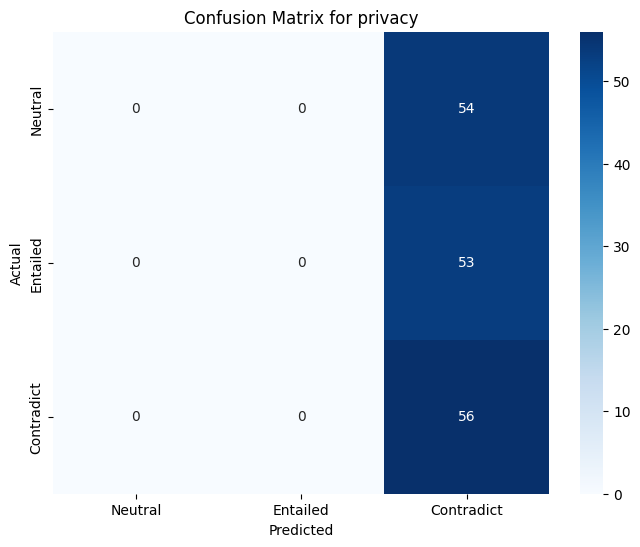

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.095700,1.084601
2,1.103600,1.084039
3,1.092900,1.102785
4,1.109800,1.263865
5,1.057900,1.026644
6,0.886400,0.871173


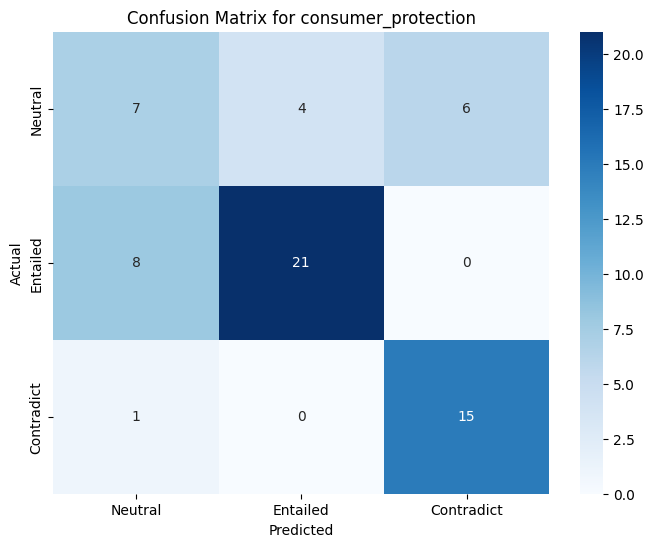

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.087300,1.111029
2,1.084900,1.110219
3,1.094200,1.108351
4,1.101700,1.095916
5,1.041100,0.987725
6,0.667800,0.953764


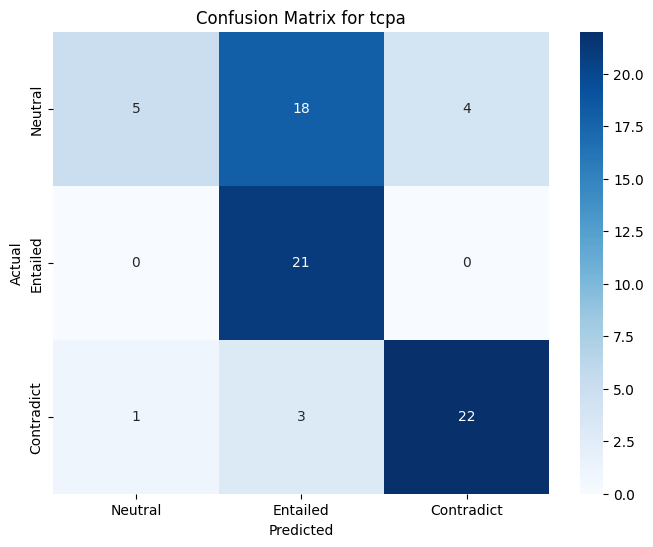

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.121700,1.091560
2,1.118700,1.090533
3,1.108600,1.092320
4,1.124900,1.094929
5,0.908200,0.831911
6,0.472800,0.859618


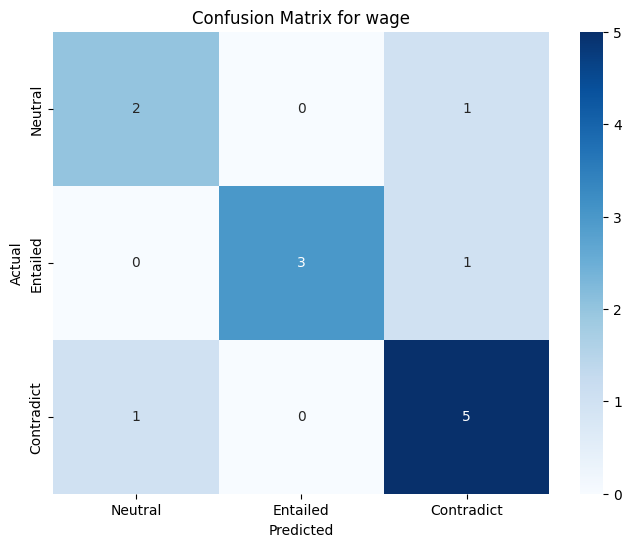

In [ ]:

for legal_act in legal_acts:
    df_train = df[df['legal_act'] != legal_act]
    df_val = df[df['legal_act'] == legal_act]
    df_val = df_val[df_val['augmentation']=='origin'] 

    
    trainer = train_and_evaluate(df_train, df_val)
    predictions, labels, _ = trainer.predict(preprocess_data(df_val['premise'].tolist(), df_val['hypothesis'].tolist(), df_val['label'].tolist(), tokenizer))
    preds = np.argmax(predictions, axis=1)
    
    all_preds.extend(preds)
    all_labels.extend(labels)
    
    report = classification_report(labels, preds, output_dict=True)
    results[legal_act] = report

    # Save the model manually at the end of each training process
    #trainer.save_model(f"./results/model_{legal_act}")
    
    
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f'Confusion Matrix for {legal_act}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"confusion_matrix_{legal_act}.png")
    plt.show()


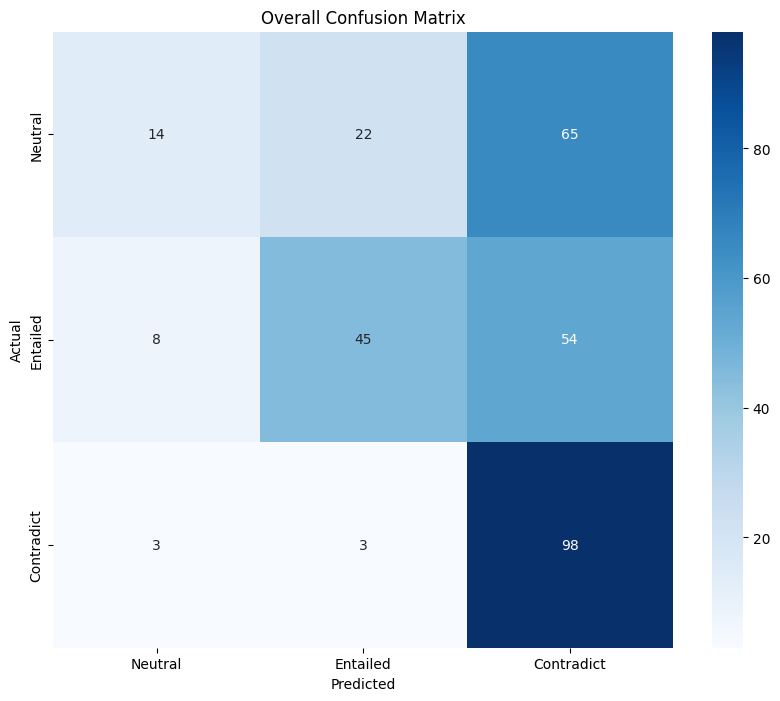

In [ ]:
# Generate overall confusion matrix
overall_cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("overall_confusion_matrix.png")
plt.show()


In [ ]:
# Print the results
for legal_act, report in results.items():
    print(f"Results for {legal_act}:")
    print(report)

Results for privacy:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 54}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 53}, '2': {'precision': 0.34355828220858897, 'recall': 1.0, 'f1-score': 0.5114155251141552, 'support': 56}, 'accuracy': 0.34355828220858897, 'macro avg': {'precision': 0.11451942740286299, 'recall': 0.3333333333333333, 'f1-score': 0.1704718417047184, 'support': 163}, 'weighted avg': {'precision': 0.11803229327411646, 'recall': 0.34355828220858897, 'f1-score': 0.17570103930302267, 'support': 163}}
Results for consumer_protection:
{'0': {'precision': 0.4375, 'recall': 0.4117647058823529, 'f1-score': 0.42424242424242425, 'support': 17}, '1': {'precision': 0.84, 'recall': 0.7241379310344828, 'f1-score': 0.7777777777777777, 'support': 29}, '2': {'precision': 0.7142857142857143, 'recall': 0.9375, 'f1-score': 0.8108108108108109, 'support': 16}, 'accuracy': 0.6935483870967742, 'macro avg': {'precision': 0.6639285714285714, 'recall': 0.

In [ ]:
# Function to create a DataFrame from results
def create_results_table(results, label_map):
    data = []
    for legal_act, metrics in results.items():
        macro_f1_score = metrics['macro avg']['f1-score']
        data.append([legal_act, round(macro_f1_score * 100, 1)])
    
    df = pd.DataFrame(data, columns=['Legal Act', 'Macro F1-Score'])
    return df

# Create the results table
results_table = create_results_table(results, label_map)
results_table

,Legal Act,Macro F1-Score
0,privacy,17.0
1,consumer_protection,67.1
2,tcpa,60.5
3,wage,76.4
